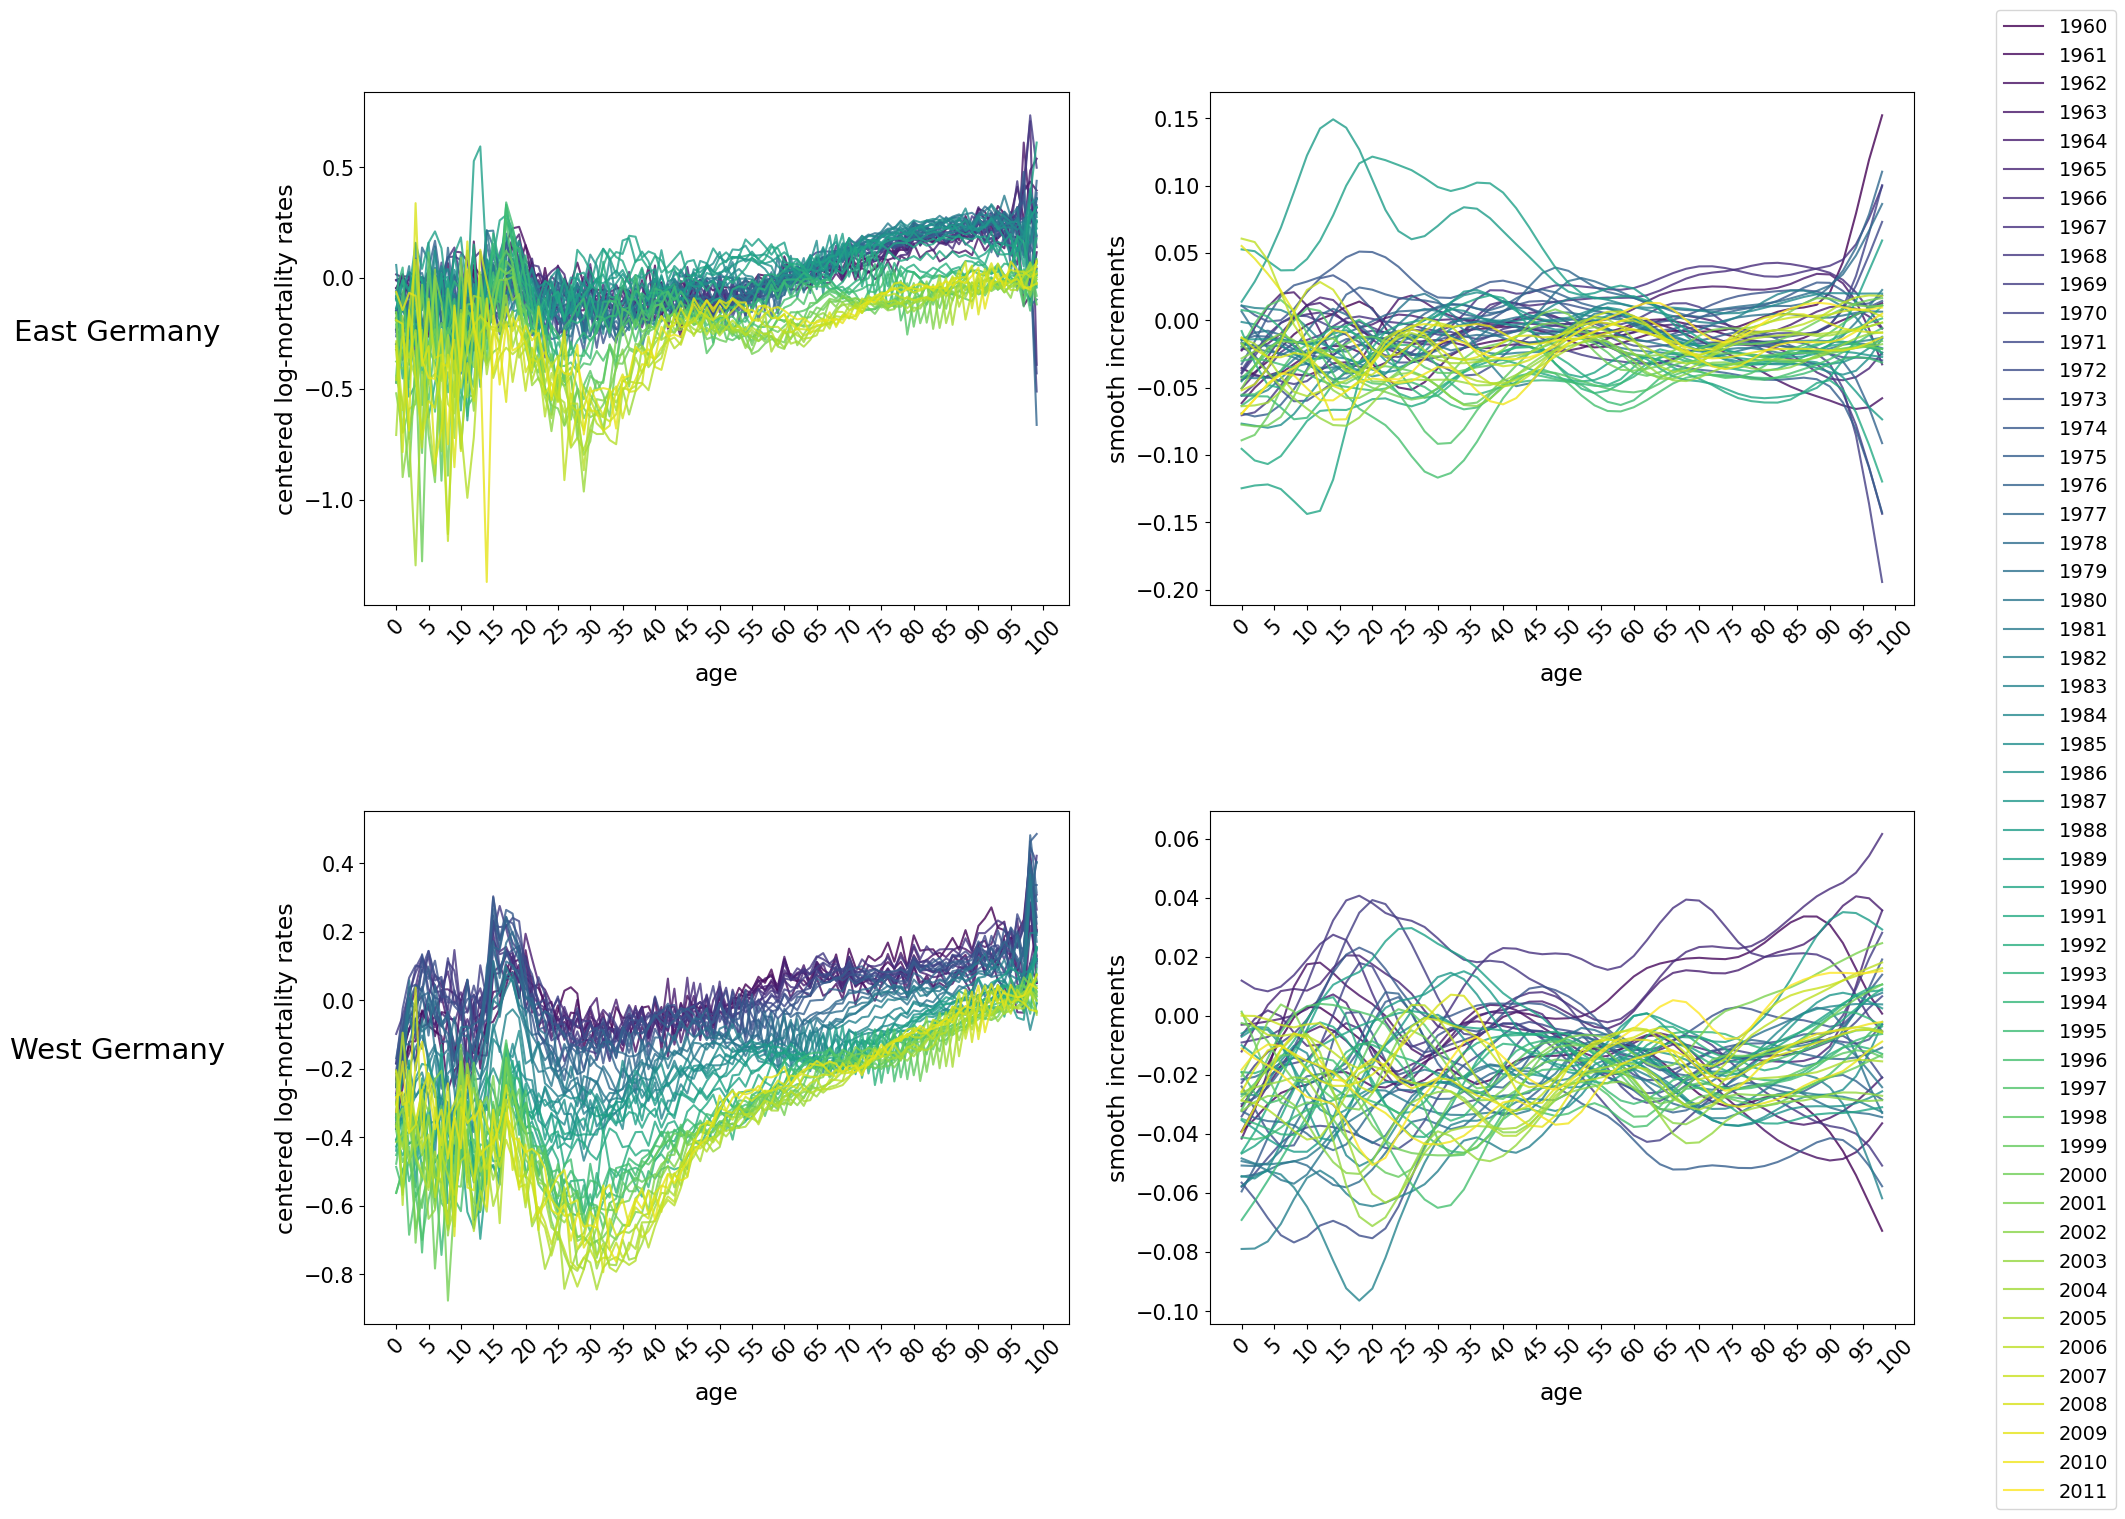

computing lag-h autocovariance kernels for each FTS...


100%|█████████████| 32/32 [00:55<00:00,  1.73s/it]


computing associated spectral density operators...


100%|█████████████| 32/32 [00:00<00:00, 34.21it/s]


computing Frechet mean flow of spectral density operators...


100%|█████████████| 51/51 [00:35<00:00,  1.44it/s]


computing elbow...


100%|█████████████| 11/11 [00:00<00:00, 33.50it/s]


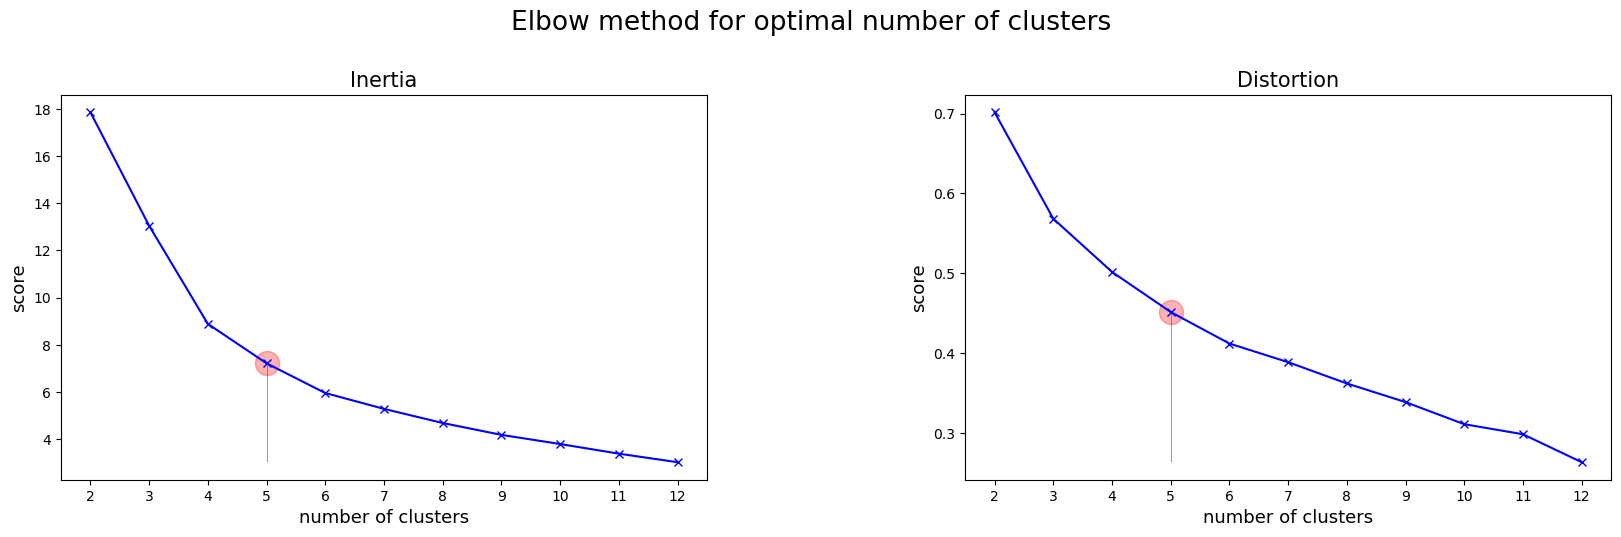

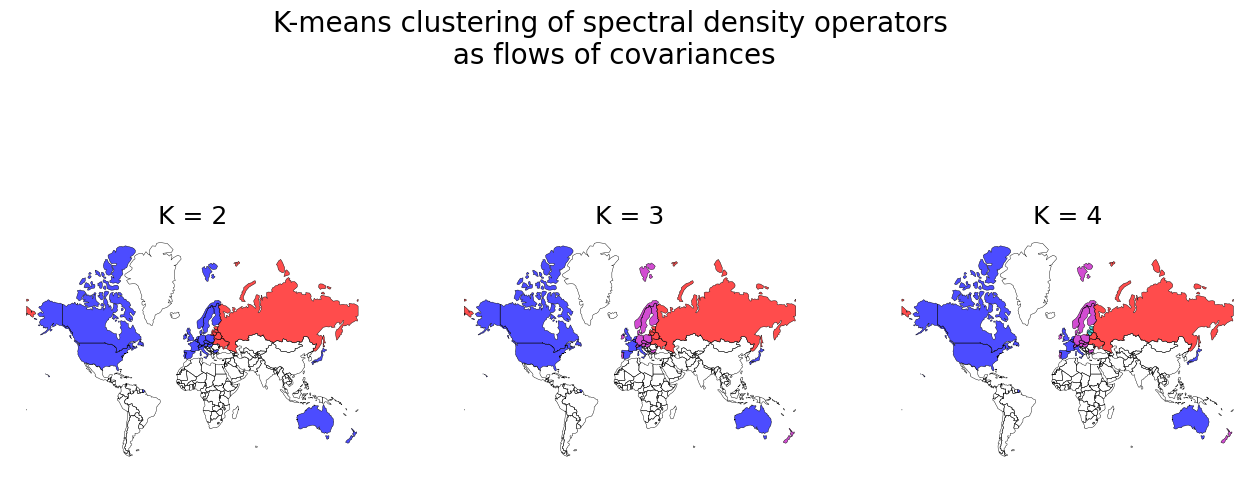

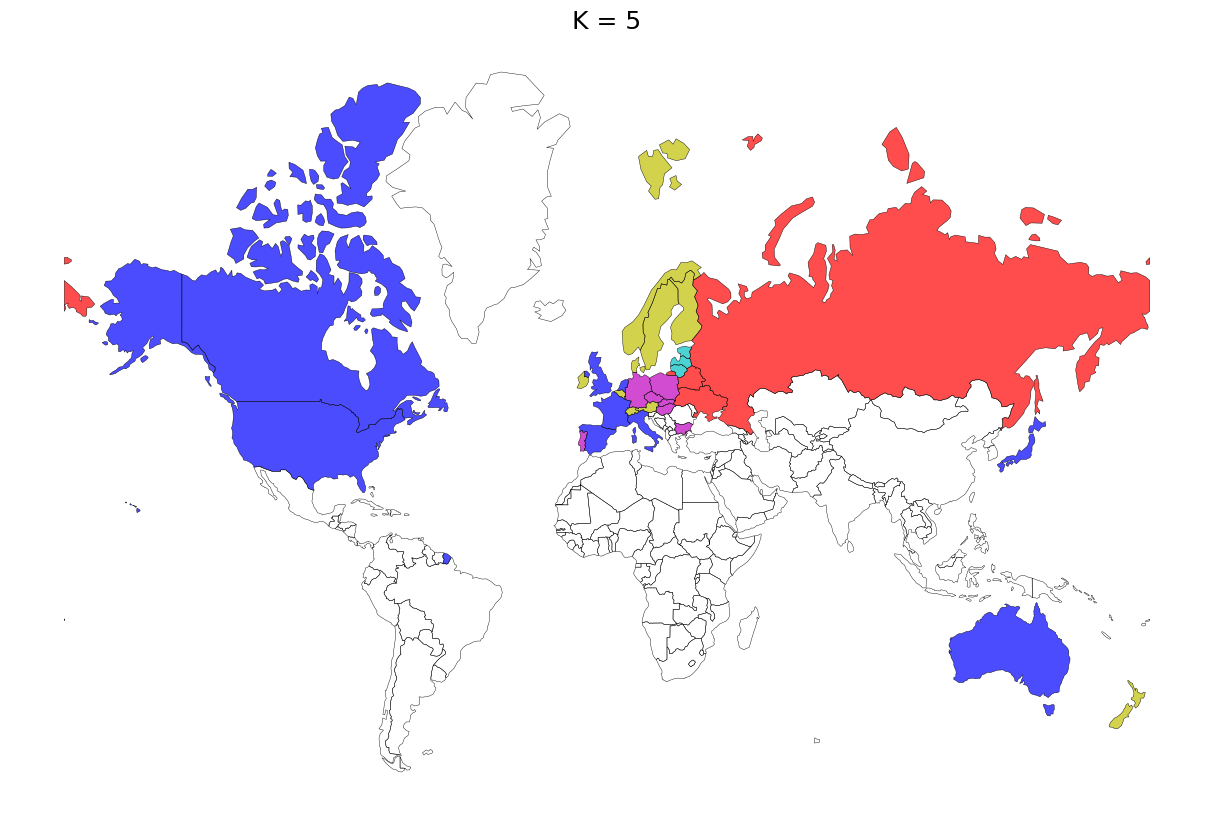

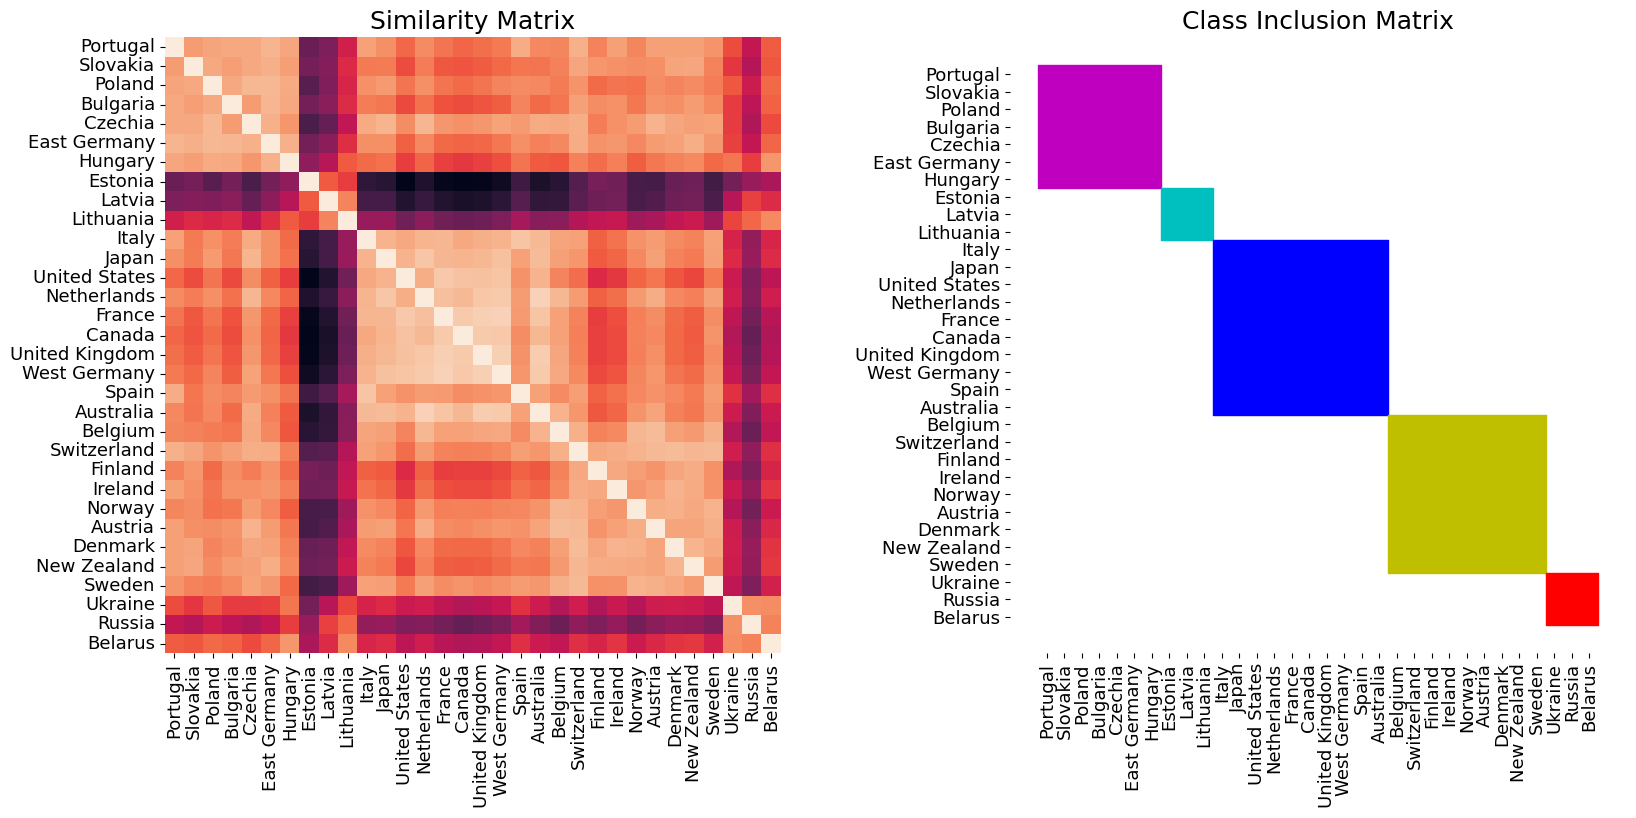

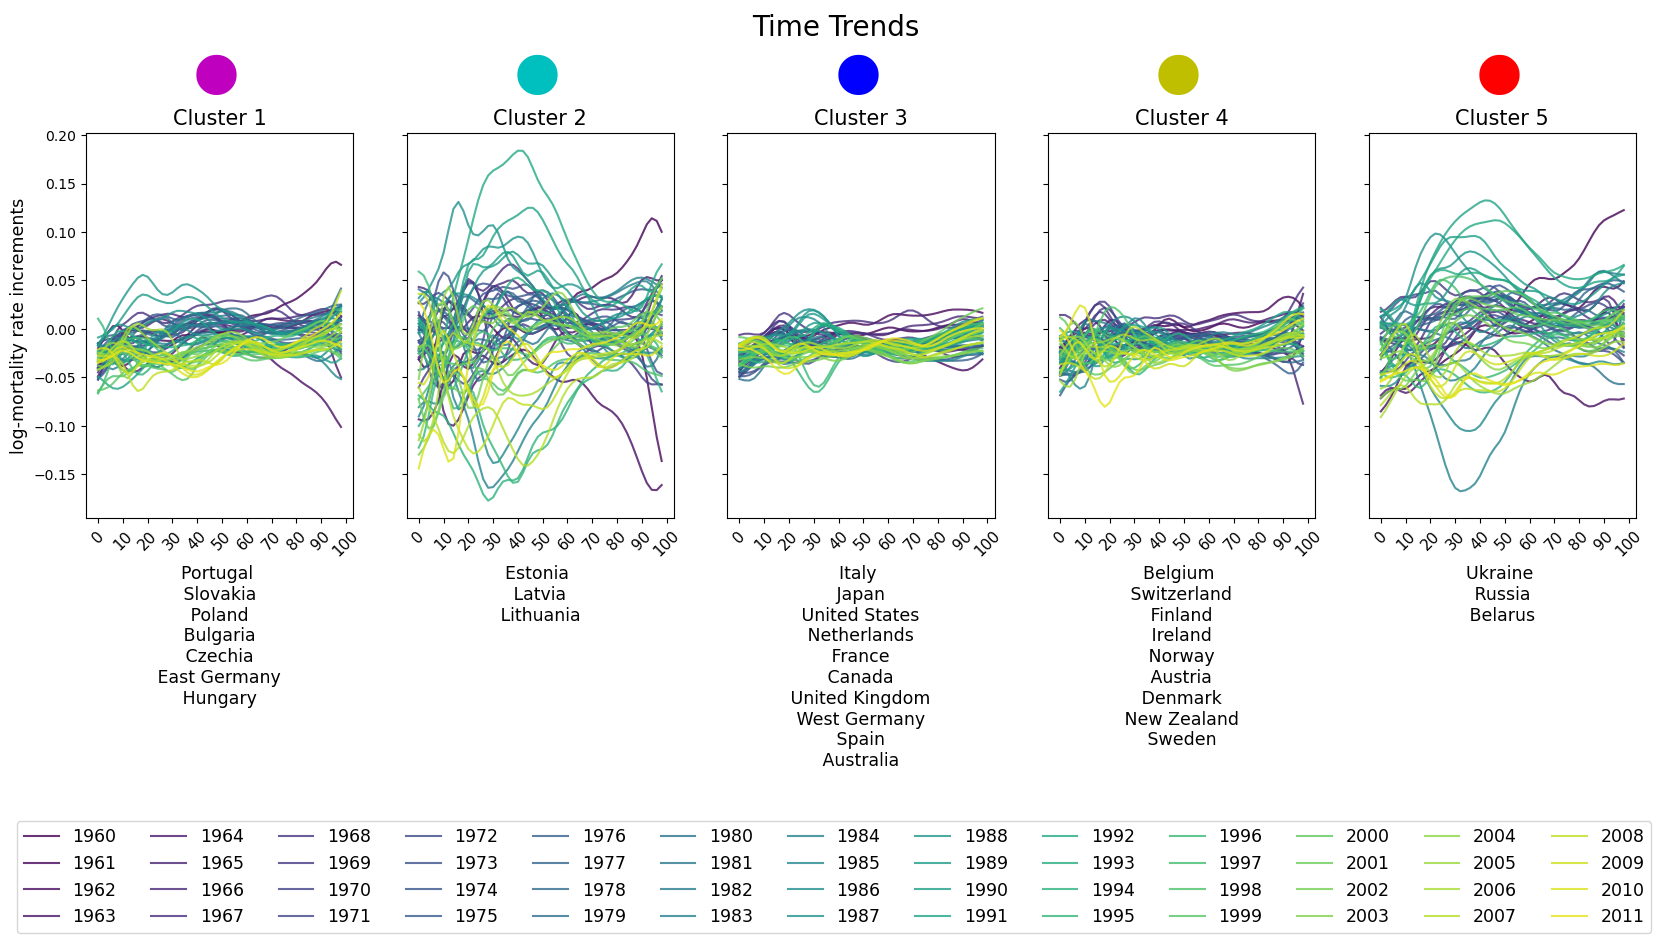

In [2]:
# library 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import skfda.preprocessing.smoothing.kernel_smoothers as ks
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from skfda import FDataGrid
from tqdm import tqdm

import sys
sys.path.append('./funs') 
from bw import *
from fts import *
from plotting_fts import *

sys.path.pop()

# select regions
selected_regions = ['JPN', 'BLR', 'UKR', 'RUS', 'GBR_NP', 'POL', 'BEL', 'CHE', 'SVK', 'USA', 'FRACNP', 'CZE', 'IRL', 'NZL_NP', 'HUN', 'AUS', 'NLD','DNK', 'NOR', 'SWE', 'ITA', 'FIN', 'PRT', 'AUT', 'ESP', 'CAN', 'LTU', 'BGR', 'EST', 'LVA',  'DEUTE', 'DEUTW']


# import mortality rates -- concatenates dataframes reporting data for each region
mypath = './data'
files_in_mypath = os.listdir(mypath); 
dfs = []
for filename in files_in_mypath:
    try:
        filepath = mypath+'/'+filename
        country = filepath[7:-11]
        df = pd.read_csv(filepath,skiprows=2,delim_whitespace=True); df.loc[:,'geoID'] = country; 
        dfs.append(df)
    except:
    	None
dfs = pd.concat(dfs)

# keep only selected regions
dfs = dfs[dfs.geoID.isin(selected_regions)]; 

# exlcude >100 age group
dfs = dfs[dfs.Age.isin([str(i) for i in range(1, 101)])]

# store list of unique regions on geoID and age groups
geoIDs = dfs.geoID.unique(); ages = dfs.Age.unique().astype(int); 

# set geoID as index
dfs = dfs.set_index('geoID')

# smoothing bandwith -- will smooth each functional time series across age groups, which are remapped to the interval [0,1]
smoothing_bandwith = 0.035

# choice of smoohting kernel
smoother = ks.NadarayaWatsonSmoother(smoothing_parameter=smoothing_bandwith)

# number of consecutive years over which to average
window = 2

# grid size -- reduced to speed up computation
_size_= 50

 # selection of time interval
years = np.arange(1960,2014)

# extract each functional time series 
# TSs : np.array, i-th entry contains the FTS corresponding to the i-th region, i.e. of shape #regions, #years, #age_groups
# XSs : np.array, i-th entry contains the differenced, smoothed FTS corresponding to the i-th region   #regions, #years-1, #age_groups
TSs = []; Xs =[]
for geoID in geoIDs:
    df = dfs.loc[geoID].copy()
    X = np.array([df[df.Year == year].Total.values.astype('float')  for year in years]);
    TSs.append(X)
    X = np.array([np.log(1e-4 + x) for x in X])    
    X = calculate_moving_average(X, 2)
    X = np.array([ smoother.fit_transform(FDataGrid(x))(np.linspace(0,1,_size_)).ravel()  for x in X])
    Xs.append(X)
TSs = np.array(TSs); Xs = np.array(Xs);

Xs = Xs[:, 1:, :] - Xs[:, :-1, :]; std = Xs.ravel().std();

# plot two
fig = plotTwoFTS(['DEUTE','DEUTW'], geoIDs, TSs,Xs,years) ;plt.show()

d = Xs.shape[-1]; Dgrid = np.linspace(0,1,d); Id = np.diag(np.ones(d))
T = Xs.shape[1]; n = Xs.shape[0]; N = T-1; freq_dom = np.linspace(-np.pi,np.pi,N)


# ridge regularisation for stability of gradient descent algorithm that computes frechet mean
reg = 1e-2; 

# threshold to stop iterative algorithm
tol = .5*reg

# lag-h autocovariance kernels
print('computing lag-h autocovariance kernels for each FTS...') 
rs = np.array( [  [ [[ r(Xs[i]/std, t,ix,iy) for ix, x in enumerate(Dgrid) ] for iy, y in enumerate(Dgrid)
                 ] for t in range(T//3*2)] for i in tqdm(np.arange(n),ncols=50)] )

# spectral density operators
print('computing associated spectral density operators...') 
fs = np.array( [  [ f(rs[i], omega) for omega in freq_dom ] for i in tqdm(np.arange(n), ncols=50)]).astype('complex128')

# FMF of spectral density operators
print('computing Frechet mean flow of spectral density operators...') 
XiHAT = np.array([ FM(fs[:,i,:,:],MaxIter = 500,  reg=reg,tol=tol)[0] for i,t in enumerate(tqdm(freq_dom, ncols=50))])

# log-projection
_embedded_log = np.array([ np.array([
    (optmap(XiHAT[t_ix], fs[i,t_ix], reg=0) - Id )@sqrtm(XiHAT[t_ix]) for t_ix, t in enumerate(freq_dom)])
                for i in range(n) ]); embedded_log = np.array([ np.array([ _.ravel() for _ in __] ).ravel()  for __ in _embedded_log])

# PCA
data = embedded_log.astype('complex128'); mean = data.mean(axis=0); center = (data - mean)
center_scaled = center/(data.shape[0]**.5)
u, s, vh = np.linalg.svd(center_scaled, full_matrices=False); 
n_components = 20
PC = vh[:n_components]; 
PCscores = (center@PC.T).T
data = np.vstack([ PCscores.real, PCscores.imag ]).T


# estimate elbow
fig = PlotElbow(data);plt.show()

# plot clusters produced by k-means with k=2,3,4
fig,axs = plt.subplots(figsize = (16,7), ncols = 3, nrows=1); axs=axs.ravel()

fig.suptitle('K-means clustering of spectral density operators\n as flows of covariances', fontsize= 20)
for k,ax in enumerate(axs):
    kmeans = KMeans(n_clusters=k+2, n_init = 100).fit(data)
    plot_clustering_onMap(kmeans, data, geoIDs,ax);
plt.show()

# more results for the case k=5
fig,ax = plt.subplots(figsize = (16,10)); k=5
kmeans = KMeans(n_clusters=k, n_init = 100).fit(data)
plot_clustering_onMap(kmeans, data, geoIDs,ax);plt.show()

fig = plot_SimilarityMatrix(kmeans, geoIDs, data) ;plt.show()

fig = plot_Trends(kmeans, Xs, geoIDs, years); plt.show()